# Retrieval Augmented Generation

Author: Arkadiusz Modzelewski

Website and contact details: [Website](https://amodzelewski.com/)

# Short Description

This notebook demonstrates how you can build an advanced RAG (Retrieval Augmented Generation) for answering a user’s question about a specific knowledge base (here, the European Election 2024), using LangChain.

# Additional Resources

[Simple RAG](https://huggingface.co/learn/cookbook/en/rag_zephyr_langchain) - Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain

[Advanced RAG](https://huggingface.co/learn/cookbook/en/advanced_rag#load-your-knowledge-base) - Advanced RAG on Hugging Face documentation using LangChain


This lab was created using Advanced RAG notebook provided by Hugging Face.

# Libraries to install

In [1]:
# !pip install langchain-community
# !pip install langchain
# !pip install pypdf
# !pip install faiss-cpu
# !pip install langchain-chroma

In [3]:
#  !pip install bitsandbytes

# Imports

In [3]:
from langchain_community.document_loaders import PyPDFLoader
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from typing import Optional, List, Tuple
from langchain_chroma import Chroma
from transformers import pipeline
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
pd.set_option("display.max_colwidth", None)

# Utils

All helper functions

In [4]:
def plot_doc_length_distribution(document_lengths, title="Distribution of Document Lengths in the Knowledge Base"):
    """
    Plots a histogram showing the distribution of document lengths.

    Parameters:
    - document_lengths (list): A list of integers representing the number of tokens in each document.
    - title (str): Title for the plot. Defaults to a general description.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(document_lengths, bins=30, color='skyblue', edgecolor='black')

    plt.title(title, fontsize=14)
    plt.xlabel("Number of Tokens", fontsize=12)
    plt.ylabel("Number of Documents", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [5]:
def split_documents(chunk_size: int, chunk_overlap: int, knowledge_base: List, tokenizer_name: str) -> List:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    docs_processed = text_splitter.split_documents(knowledge_base)

    return docs_processed

# Load your knowledge base

In [6]:
# Define the path to the PDF file containing the knowledge base
file_path = "../data/2024_European_Parliament_election_Wikipedia.pdf"

# Create a PyPDFLoader object to handle loading of the PDF
loader = PyPDFLoader(file_path)

# Load the contents of the PDF into a variable for further processing
RAW_KNOWLEDGE_BASE = loader.load()

In [7]:
type(RAW_KNOWLEDGE_BASE)

list

In [8]:
len(RAW_KNOWLEDGE_BASE)

14

In [9]:
RAW_KNOWLEDGE_BASE[0]

Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-16T13:48:40+00:00', 'title': '2024 European Parliament election - Wikipedia', 'moddate': '2025-05-16T13:48:40+00:00', 'source': '../data/2024_European_Parliament_election_Wikipedia.pdf', 'total_pages': 14, 'page': 0, 'page_label': '1'}, page_content='2024 European Parliament election\n6–9 June 2024\nAll 720 seats to the European Parliament[a]\n361 seats needed for a majority\nOpinion\xa0polls\nTurnout (50.74%[1] \n 0.08 pp)\n\xa0\nLeader Ursula von derLeyen Nicolas Schmit None[b]\nAlliance EPP S&D PfE\nLeader\'s\xa0seat Not running Not running –\nLast\xa0election 187 seats 148 seats New group\nSeats\xa0won 188 136 84\nSeat\xa0change\n  1\n  12\n  8[c]\n\xa0\nLeader None Marie-AgnesStrack-Zimmermann[d]\nTerry ReintkeBas Eickhout\nAlliance ECR Renew Greens/EFA\nLeader\'s\xa0seat – Germa

In [10]:
RAW_KNOWLEDGE_BASE[0].metadata

{'producer': 'Skia/PDF m136',
 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36',
 'creationdate': '2025-05-16T13:48:40+00:00',
 'title': '2024 European Parliament election - Wikipedia',
 'moddate': '2025-05-16T13:48:40+00:00',
 'source': '../data/2024_European_Parliament_election_Wikipedia.pdf',
 'total_pages': 14,
 'page': 0,
 'page_label': '1'}

In [11]:
RAW_KNOWLEDGE_BASE[0].page_content

'2024 European Parliament election\n6–9 June 2024\nAll 720 seats to the European Parliament[a]\n361 seats needed for a majority\nOpinion\xa0polls\nTurnout (50.74%[1] \n 0.08 pp)\n\xa0\nLeader Ursula von derLeyen Nicolas Schmit None[b]\nAlliance EPP S&D PfE\nLeader\'s\xa0seat Not running Not running –\nLast\xa0election 187 seats 148 seats New group\nSeats\xa0won 188 136 84\nSeat\xa0change\n  1\n  12\n  8[c]\n\xa0\nLeader None Marie-AgnesStrack-Zimmermann[d]\nTerry ReintkeBas Eickhout\nAlliance ECR Renew Greens/EFA\nLeader\'s\xa0seat – Germany GermanyNetherlands\nLast\xa0election 62 seats 97 seats 67 seats\nSeats\xa0won 78 77 53\nSeat\xa0change\n  16\n  20\n  14\n\xa0\nLeader Walter Baier None\nAlliance The Left ESN\nLeader\'s\xa0seat Not running –\nLast\xa0election 40 seats New group\nSeats\xa0won 46 25\nSeat\xa0change\n  6 –\n2024 European Parliament election\nThe 2024 European Parliament election was held in the European Union(EU) between 6 and 9 June 2024.[4] It was the tenth parliam

In [12]:
len(RAW_KNOWLEDGE_BASE[0].page_content)

4927

# Retriever

## Split the documents into chunks

In this part, we split the documents from our knowledge base into smaller chunks which will be the snippets on which the reader LLM will base its answer. The goal is to prepare a collection of semantically relevant snippets. So their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them. A widely used and simple method for chunking text involves specifying a fixed chunk size and determining if the chunks should overlap. Including some overlap helps maintain semantic continuity between chunks. For general-purpose text, the recommended tool is the `RecursiveCharacterTextSplitter`, which we’ll be using in this case.


The `chunk_size` parameter determines the maximum length of each chunk - measured in characters by default.
Meanwhile, the `chunk_overlap` parameter allows neighboring chunks to share some content. This overlap helps ensure that important ideas aren't accidentally split between chunks, preserving the semantic integrity of the text.

In [14]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=20,  # The number of characters to overlap between chunks
)

chunked_docs = splitter.split_documents(RAW_KNOWLEDGE_BASE)

In [15]:
type(chunked_docs)

list

In [16]:
len(chunked_docs)

41

In [17]:
chunked_docs[0]

Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-16T13:48:40+00:00', 'title': '2024 European Parliament election - Wikipedia', 'moddate': '2025-05-16T13:48:40+00:00', 'source': '2024_European_Parliament_election_Wikipedia.pdf', 'total_pages': 14, 'page': 0, 'page_label': '1'}, page_content="2024 European Parliament election\n6–9 June 2024\nAll 720 seats to the European Parliament[a]\n361 seats needed for a majority\nOpinion\xa0polls\nTurnout (50.74%[1] \n 0.08 pp)\n\xa0\nLeader Ursula von derLeyen Nicolas Schmit None[b]\nAlliance EPP S&D PfE\nLeader's\xa0seat Not running Not running –\nLast\xa0election 187 seats 148 seats New group\nSeats\xa0won 188 136 84\nSeat\xa0change\n  1\n  12\n  8[c]\n\xa0\nLeader None Marie-AgnesStrack-Zimmermann[d]\nTerry ReintkeBas Eickhout\nAlliance ECR Renew Greens/EFA\nLeader's\xa0seat – Germany Germany

In [18]:
chunked_docs[2].metadata

{'producer': 'Skia/PDF m136',
 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36',
 'creationdate': '2025-05-16T13:48:40+00:00',
 'title': '2024 European Parliament election - Wikipedia',
 'moddate': '2025-05-16T13:48:40+00:00',
 'source': '2024_European_Parliament_election_Wikipedia.pdf',
 'total_pages': 14,
 'page': 0,
 'page_label': '1'}

In [19]:
len(chunked_docs[0].page_content)

1994

It's important to remember that when embedding documents, the embedding model has a maximum sequence length, defined by max_seq_length.

Therefore, our chunk sizes should stay within this limit. If a chunk exceeds the maximum length, it will be truncated during processing, potentially resulting in the loss of important or relevant information.

In [20]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object
# max_seq_length - number of tokens
model = SentenceTransformer('thenlper/gte-small')
print(f"Model's maximum sequence length: {model.max_seq_length}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


In [21]:
# Load a pre-trained tokenizer from the Hugging Face model hub.
# "thenlper/gte-small" is the model identifier for a lightweight embedding model.
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")

# For each document chunk, tokenize the text content and calculate its token length.
# tqdm is used to display a progress bar for better visibility during processing.
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(chunked_docs)]

  0%|          | 0/41 [00:00<?, ?it/s]

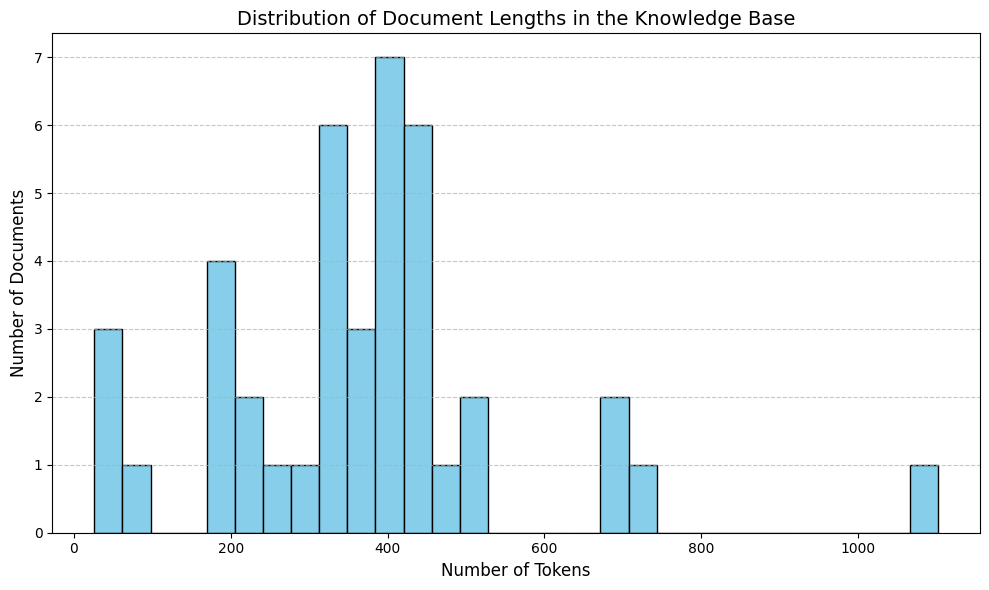

In [22]:
plot_doc_length_distribution(document_lengths=pd.Series(lengths))

As shown, the chunk lengths don't consistently stay within the 512-token limit, some exceed it. This means portions of those longer chunks will be truncated during processing, potentially leading to loss of valuable content.

Let's try with smaller chunk size.

In [23]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=50,  # The number of characters to overlap between chunks
)

chunked_docs = splitter.split_documents(RAW_KNOWLEDGE_BASE)

In [24]:
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(chunked_docs)]

  0%|          | 0/137 [00:00<?, ?it/s]

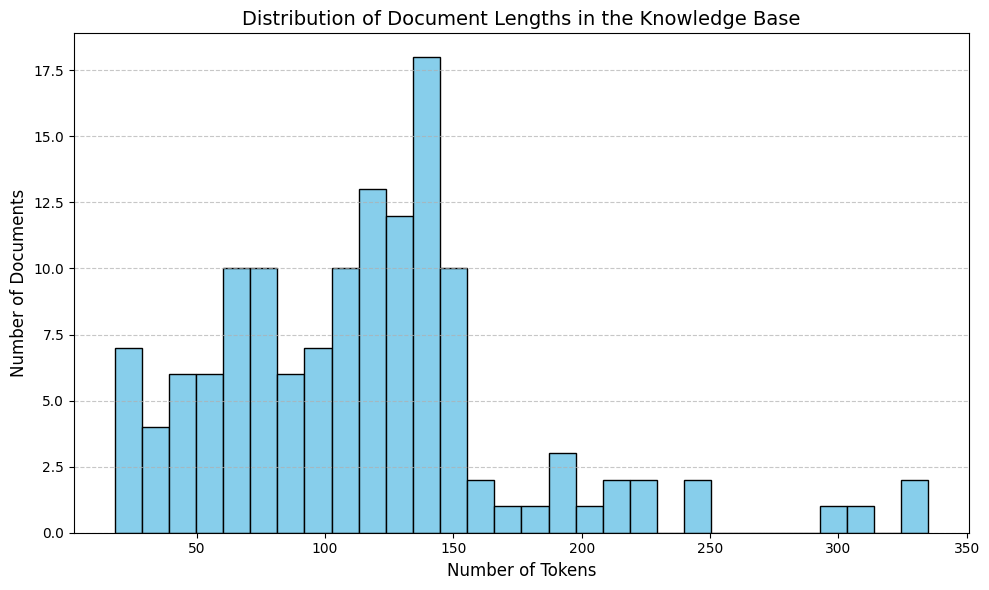

In [25]:
plot_doc_length_distribution(document_lengths=pd.Series(lengths))

This code sets the embedding model to `gte-small`, a lightweight language model for general-purpose text embeddings, and processes a raw knowledge base by splitting its documents into chunks of up to certian number of tokens using the model's tokenizer. The split_documents function ensures chunks have slight overlaps.

In [65]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

docs_processed = split_documents(
    chunk_size=512,
    chunk_overlap=50,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

  0%|          | 0/39 [00:00<?, ?it/s]

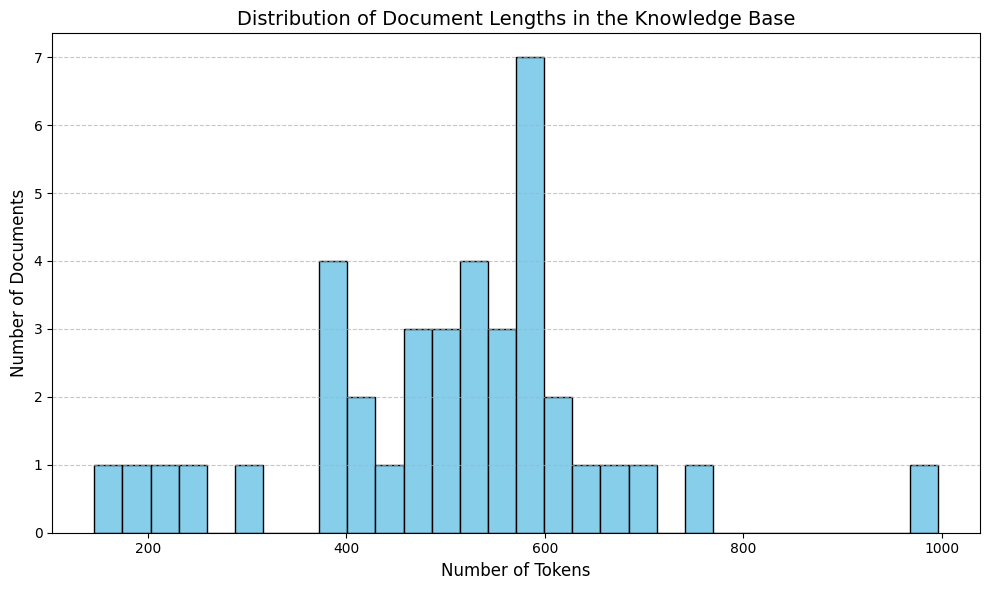

In [66]:
# Let's visualize the chunk sizes we would have in tokens from a common model
# tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

plot_doc_length_distribution(document_lengths=pd.Series(lengths))

This code initializes a HuggingFaceEmbeddings model using the previously defined gte-small, enabling GPU acceleration and normalization of embeddings for cosine similarity.

In [67]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

Now we are creating a Chroma vector store (vector_store) from the preprocessed documents, storing the embeddings in a persistent directory (db1) and configuring it to use cosine similarity for nearest neighbor search.

In [68]:
vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db5",
    collection_metadata={"hnsw:space": "cosine"}
)

This code performs a semantic search in the Chroma vector store by first embedding the query **"What are results of European Election in 2024?"** using the `gte-small` embedding model. It then retrieves the top 4 most similar document chunks (`k=4`) based on cosine similarity.

In [69]:
results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("What are results of European Election in 2024?"), k=4
)

In [70]:
len(results)

4

This code loads the **Phi-3 Mini** language model (`microsoft/Phi-3-mini-4k-instruct`) with 4-bit quantization using `BitsAndBytesConfig` to reduce memory usage while maintaining performance. It sets up the model for efficient inference (e.g., using `bfloat16` for computation) and loads the corresponding tokenizer for text processing.

This code sets up a configuration for loading a machine learning model, specifically a variant of Microsoft's **Phi-3** model, using **4-bit quantization** to reduce memory usage and increase inference speed. Here's what each part does:

---


`BitsAndBytesConfig`

This sets up **quantization** settings from the `BitsAndBytes` library, often used with Hugging Face Transformers to save memory.


Explanation:

* `load_in_4bit=True`: Loads the model weights in 4-bit precision (saves memory).
* `bnb_4bit_use_double_quant=True`: Applies double quantization for improved accuracy.
* `bnb_4bit_quant_type="nf4"`: Uses "Normal Float 4" quantization, designed to retain performance while using fewer bits.
* `bnb_4bit_compute_dtype=torch.bfloat16`: Uses the `bfloat16` format during computation, offering a good tradeoff between speed and precision on modern GPUs (like Ampere or later).

---

### Summary

This code prepares a **memory-efficient, fast-loading configuration** for using the `Phi-3-mini-4k-instruct` language model. It’s useful when deploying models on limited hardware while trying to maintain reasonable inference accuracy.

In [35]:
READER_MODEL_NAME = "microsoft/Phi-3-mini-4k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

This code creates a text generation pipeline named `READER_LLM` using the previously loaded **Phi-3 Mini** model and tokenizer. It configures the generation to produce up to 500 new tokens with controlled creativity (`temperature=0.2`), reduced repetition (`repetition_penalty=1.1`), and sampling enabled, returning only the generated continuation (not the input prompt).

---


Parameters:

* **`model=model`**: The pretrained model object.
* **`tokenizer=tokenizer`**: The tokenizer associated with the model.
* **`task="text-generation"`**: Specifies the pipeline task – in this case, **text generation**.
* **`temperature=0.2`**: Controls randomness. A **low temperature** like `0.2` means **more deterministic** and focused output (less creativity).
* **`repetition_penalty=1.1`**: Penalizes repeated phrases to improve diversity in the output.
* **`return_full_text=False`**: Returns only the **generated portion** of text, not the input prompt + output.
* **`max_new_tokens=500`**: The maximum number of new tokens (words/subwords) to generate in the output.

---



In [36]:
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Device set to use cuda:0


In [37]:
READER_LLM("What are results of European Election in 2024?")

[{'generated_text': "\n\nI'm interested to know the outcome and key highlights from a hypothetical or real scenario where there is an upcoming election for the President, Parliament members etc. Could you provide me with some insights on what might happen after such elections based on past trends or possible scenarios if this were happening right now? Certainly! As I don't have access to future events post-March 2023 due to my last update being that date, let's discuss how outcomes could be analyzed following major political events like presidential or parliamentary elections within Europe using historical context as our guide:\n\n1. **Electoral System Analysis** - The structure of each country’s electoral system (proportional representation vs first-past-the-post) can greatly influence the distribution of seats among parties. For instance, countries utilizing proportional systems may see more fragmentation of power across multiple smaller parties compared to those employing majority v

This code defines a **chat-style prompt template** (`prompt_in_chat_format`) for guiding a language model like Phi-3 Mini. It simulates a conversation where:

* The **"system"** provides clear instructions: answer only using the given context, be concise, cite source document numbers when relevant, and avoid guessing if the answer isn't in the context.
* The **"user"** then supplies the actual **context and question**, which will be dynamically filled in using `{context}` and `{question}` placeholders during inference.

In [38]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context, give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question. If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context: {context}
        ---
        Now here is the question you need to answer.
        Question: {question}""",
    },
]

This code uses the **Phi-3 tokenizer's `apply_chat_template`** method to convert the structured `prompt_in_chat_format` (a list of chat roles and messages) into a **formatted text prompt** suitable for text generation.

In [71]:
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format,
    tokenize=False, # Return a string, not token IDs
    add_generation_prompt=True # Ensures model knows where to start generating
)

print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context, give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question. If the answer cannot be deduced from the context, do not give an answer.<|end|>
<|user|>
Context: {context}
        ---
        Now here is the question you need to answer.
        Question: {question}<|end|>
<|assistant|>


This code extracts the text content (`page_content`) from each document in the `results` list, then builds a single `context` string by concatenating these texts. This formatted context can then be used as input for a language model to provide answers based on the retrieved documents.

In [72]:
retrieved_docs_text = [doc.page_content for doc in results]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

In [73]:
len(context)

5380

This line fills in the placeholders in the `prompt_in_chat_format` by injecting the actual question **"What are results of European Election in 2024?"** and the previously built `context` string containing the retrieved documents. The result is a complete prompt ready to be fed into the language model for answering based on the given context.

In [74]:
final_prompt = RAG_PROMPT_TEMPLATE.format(question="What are results of European Election in 2024?", context=context)

This code sends the fully formatted prompt (`final_prompt`) to the language model pipeline `READER_LLM` to generate a concise answer based on the provided context and question. It then extracts the generated text from the model’s output and prints the final answer.

In [75]:
# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [76]:
answer

' Results of the 2024 European Parliament election show that there were significant changes among political parties across various regions within the EU. Here’s what happened according to different sources as per your query:\n\n**European Parliment Document Analysis:**\n\nIn terms of overall seat distribution post-election, we have these numbers based on document analysis:\n\n- **EPP Group & Renew Europe combined** gained additional members bringing their count up to 188 out of 720 available seats. They had previously secured 187 seats prior to this particular election cycle.\n- **Socialists & Democrats (S&D), Green/Refoundation Europapartei (GRECE)/Renew Europe alliance** maintained its stronghold but increased slightly to hold onto 136 seats compared to previous counts like 136 or even higher depending upon past cycles.\n- **Identity and Democracy (IDEN)** saw growth due to recentralization efforts gaining them another set of votes leading to a new high of 84 seats. Their predecessor

Let's try to run same question, but we will change this time `chunk_size` and `chunk_overlap`

In [77]:
docs_processed = split_documents(
    chunk_size=200,
    chunk_overlap=40,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("What are results of European Election in 2024?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What are results of European Election in 2024?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [78]:
answer

" In the 2024 European Parliament election, there were seven political groups that won varying numbers of seats across different EU Member States. Here are their respective seat wins according to Document 1:\n\nEPP Group led by Nicolas Schmit gained 188 out of 720 available seats (+1).\nS&D Group headed by Terence Reintke secured 136 seats (+1), while its predecessor had 148 before this year’s election (-13).\nECR Group under Bas Eickhout obtained 84 seats (+8); previously they didn't exist as a separate entity but combined forces with EFDD which now holds no additional seats compared to last term due to changes within it.\nERGA composed of Green & Yellow Alliance members managed to win 77 seats; however, prior years saw them having significantly fewer votes leading up until recent shifts towards greater support among certain demographics or regions over others—this shift isn't quantified precisely yet without further analysis into individual country performances beyond aggregate total